In [1]:
import  numpy as np
import matplotlib as plt

In [15]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit

from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller


In [3]:
#Exact solver for reference:
def Exact_solver(qubitOp):
    ex = NumPyEigensolver(qubitOp)
    result = ex.run()
    ref = result['eigenvalues']
    return ref

In [4]:
basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'H .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))
#print('# one elctron integral:\n',h1)
#print('# two elctron integral:\n',h2)

HF energy: -1.3194643767935124
# nr. of electrons: 2
# nr. of spin orbitals: 4


In [5]:
ferOp = FermionicOperator(h1=h1, h2=h2)
qubitOp = ferOp.mapping(map_type='jordan_wigner')

In [6]:
print(qubitOp)
print(qubitOp.print_details())

weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label)


Representation: paulis, qubits: 4, size: 15
IIII	(-0.8517840380466501+0j)
IIIZ	(0.10053557435398452+0j)
IIZI	(-0.049032364414860446+0j)
IZII	(0.10053557435398452+0j)
ZIII	(-0.04903236441486046+0j)
IIZZ	(0.08678749878785741+0j)
IZIZ	(0.14120468151365048+0j)
XXYY	(0.05575552226867875+0j)
YYYY	(0.05575552226867875+0j)
XXXX	(0.05575552226867875+0j)
YYXX	(0.05575552226867875+0j)
ZIIZ	(0.14254302105653616+0j)
IZZI	(0.14254302105653616+0j)
ZIZI	(0.14891189696596438+0j)
ZZII	(0.08678749878785741+0j)



In [7]:
class swap_t:
    def __init__(self,theata):
        self.theta=theata
        self.mat=np.array([[1,0,0,0],
                           [0,np.sin(self.theta),-1*np.cos(self.theta),0],
                           [0,np.cos(self.theta),np.sin(self.theta),0],
                           [0,0,0,1]])

In [24]:
def U_t(theta):
    qc=QuantumCircuit(2,name='U_t('+str(theta)+')')
    qc.unitary(swap_t(theta).mat,[0,1])
    return qc.to_gate()

In [25]:
def ansatz_cell(qc,qo,nr_o, nr_e,thetas):
    
    #qo=QuantumRegister(nr_o,'qo')
    #qc=QuantumCircuit(qo,name='ansatz_cell')
    
    it=iter(thetas)
    start=nr_e-1
    limit=nr_o
    while start!=-1:
        cq=start
        tq=start+1
        while tq<limit:
            qc.append(U_t(next(it)),[cq,tq])
            cq=cq+1
            tq=tq+1

        start=start-1
        limit=limit-1
    return qc 


In [28]:
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
print(theta)

[0. 0. 0. 0.]


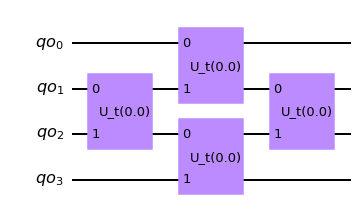

In [51]:
qo=QuantumRegister(nr_o,'qo')
ansatz = QuantumCircuit(qo)
ansatz_cell(ansatz,qo,nr_o, nr_e,theta)
ansatz.draw('mpl')

In [ ]:
optimizer= COBYLA(maxiter=500)
backend = Aer.get_backend('statevector_simulator')

In [ ]:
vqe = VQE(qubitOp, ansatz, optimizer)
result = vqe.run(backend)
print('VQE:',result.eigenvalue.real ,'Reference:', Exact_solver(qubitOp))